In [1]:
# ============================================================================
# COMPARATIVE ANALYSIS OF COMPUTATIONAL INTELLIGENCE MODELS
# FOR HEART DISEASE PREDICTION
# ============================================================================
# Author: Senior Computational Intelligence Engineer
# Course: Computational Intelligence
# Dataset: heart.csv (UCI Heart Disease Dataset)
# ============================================================================

# ============================================================================
# SECTION 1: IMPORTS & ENVIRONMENT SETUP
# ============================================================================

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn preprocessing and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Baseline models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Fuzzy Logic - scikit-fuzzy (with error handling)
FUZZY_AVAILABLE = False
try:
    import skfuzzy as fuzz
    from skfuzzy import control as ctrl
    FUZZY_AVAILABLE = True
    print("✓ scikit-fuzzy loaded successfully")
except ImportError:
    print("⚠ scikit-fuzzy not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-fuzzy", "--break-system-packages"])
    try:
        import skfuzzy as fuzz
        from skfuzzy import control as ctrl
        FUZZY_AVAILABLE = True
        print("✓ scikit-fuzzy installed and loaded successfully")
    except Exception as e:
        print(f"✗ Could not load scikit-fuzzy: {e}")
        print("  Fuzzy logic models will be skipped in this analysis.")

# Set random seeds for reproducibility
# CRITICAL for ensuring consistent results across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("COMPUTATIONAL INTELLIGENCE PROJECT: HEART DISEASE PREDICTION")
print("=" * 70)
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Fuzzy Logic Available: {FUZZY_AVAILABLE}")
print("Environment setup complete.\n")

ModuleNotFoundError: No module named 'tensorflow'

Loading dataset...
⚠ heart.csv not found locally. Downloading from UCI repository...
✓ Dataset downloaded and saved as heart.csv

DATASET EXPLORATION

Dataset Shape: (303, 14)
Number of samples: 303
Number of features: 13

First 5 rows of the dataset:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       1  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Column Names and Data Types:
age         float64
sex         float64
cp          float64
trestbps    flo

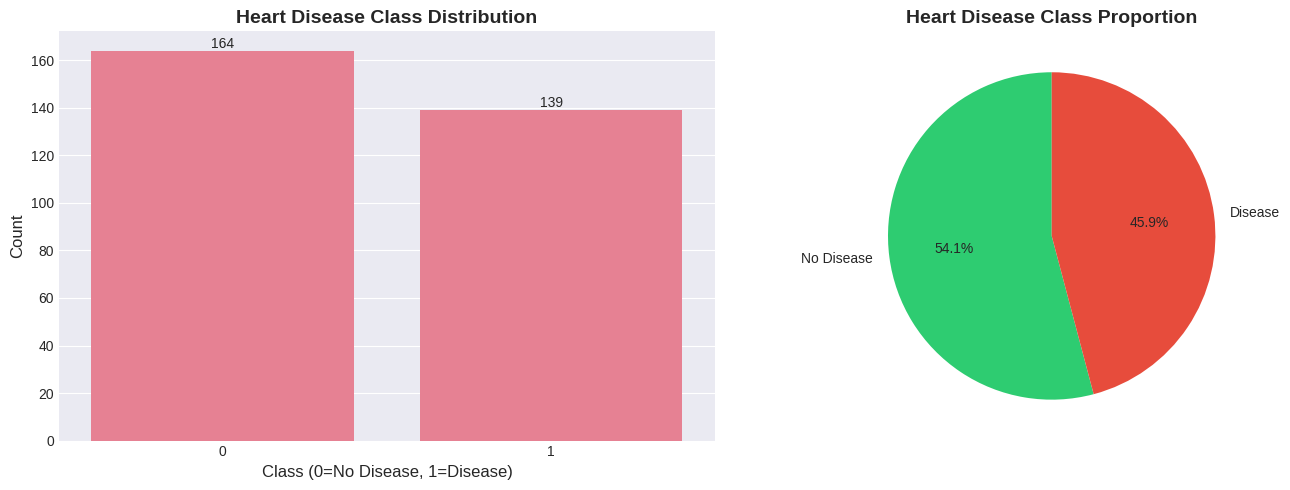


FEATURE CORRELATION ANALYSIS


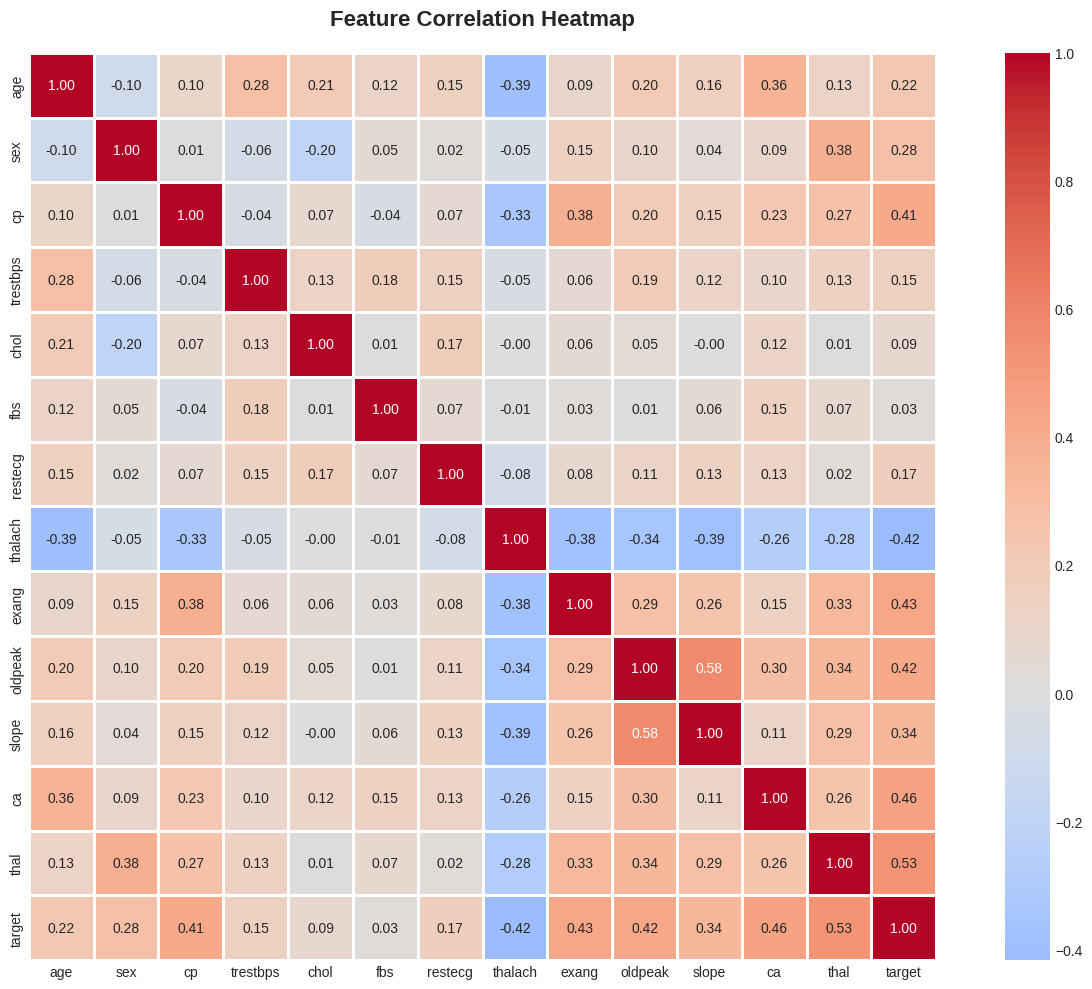


Feature Correlations with Target Variable:
target      1.000000
thal        0.525689
ca          0.460442
exang       0.431894
oldpeak     0.424510
cp          0.414446
slope       0.339213
sex         0.276816
age         0.223120
restecg     0.169202
trestbps    0.150825
chol        0.085164
fbs         0.025264
thalach    -0.417167
Name: target, dtype: float64

DATA EXPLORATION COMPLETE


In [ ]:
# ============================================================================
# SECTION 2: DATA LOADING & EXPLORATION
# ============================================================================

# Load the heart disease dataset
# Dataset contains medical attributes for heart disease prediction
# Target variable: 0 = No disease, 1 = Disease present
print("Loading dataset...")

# Try multiple sources for the dataset
df = None
dataset_loaded = False

# Option 1: Check if file exists in current directory
import os
if os.path.exists('heart.csv'):
    df = pd.read_csv('heart.csv')
    dataset_loaded = True
    print("✓ Dataset loaded from current directory")

# Option 2: Try common upload locations
if not dataset_loaded:
    upload_paths = [
        '/content/heart.csv',  # Google Colab
        '/mnt/user-data/uploads/heart.csv',  # Claude Code
        './data/heart.csv',
        '../heart.csv'
    ]
    for path in upload_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            dataset_loaded = True
            print(f"✓ Dataset loaded from {path}")
            break

# Option 3: Download from UCI repository
if not dataset_loaded:
    print("⚠ heart.csv not found locally. Downloading from UCI repository...")
    try:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

        # Column names for Cleveland dataset
        column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                       'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                       'ca', 'thal', 'target']

        df = pd.read_csv(url, names=column_names, na_values='?')

        # Convert target to binary (0 = no disease, 1-4 = disease)
        df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

        # Save locally for future use
        df.to_csv('heart.csv', index=False)
        dataset_loaded = True
        print("✓ Dataset downloaded and saved as heart.csv")
    except Exception as e:
        print(f"✗ Could not download dataset: {e}")

# Option 4: Use sample Kaggle dataset
if not dataset_loaded:
    print("⚠ Trying alternative Kaggle heart disease dataset...")
    try:
        url = "https://raw.githubusercontent.com/rashida048/Datasets/master/heart.csv"
        df = pd.read_csv(url)
        df.to_csv('heart.csv', index=False)
        dataset_loaded = True
        print("✓ Dataset downloaded from alternative source")
    except Exception as e:
        print(f"✗ Could not download from alternative source: {e}")

# If all options fail, provide instructions
if not dataset_loaded or df is None:
    print("\n" + "=" * 70)
    print("ERROR: Could not load dataset")
    print("=" * 70)
    print("\nPlease upload 'heart.csv' using one of these methods:")
    print("1. Click the 📁 Files icon in the left sidebar")
    print("2. Upload your heart.csv file")
    print("3. Or download from: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset")
    print("\nThen re-run this cell.")
    print("=" * 70)
    raise FileNotFoundError("heart.csv not found. Please upload the dataset.")

print("\n" + "=" * 70)
print("DATASET EXPLORATION")
print("=" * 70)

# Display basic information
print("\nDataset Shape:", df.shape)
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 1}")  # Excluding target

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Column information
print("\nColumn Names and Data Types:")
print(df.dtypes)

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values per Column:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")

# Dataset information
print("\nDataset Information:")
print(df.info())

# CRITICAL: Identify target variable
# Common target column names: 'target', 'HeartDisease', 'condition', etc.
possible_targets = ['target', 'HeartDisease', 'condition', 'output', 'num']
target_col = None

for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

# If standard names not found, use last column as target
if target_col is None:
    target_col = df.columns[-1]
    print(f"\nAssuming last column '{target_col}' is the target variable")

print(f"\nTarget Variable: '{target_col}'")
print("\nClass Distribution:")
print(df[target_col].value_counts())
print("\nClass Distribution (%):")
print(df[target_col].value_counts(normalize=True) * 100)

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x=target_col, ax=axes[0])
axes[0].set_title('Heart Disease Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0=No Disease, 1=Disease)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Add value labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container)

# Pie chart
class_counts = df[target_col].value_counts()
axes[1].pie(class_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
            startangle=90, colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Heart Disease Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Display correlation matrix for numerical features
print("\n" + "=" * 70)
print("FEATURE CORRELATION ANALYSIS")
print("=" * 70)

# Select numerical columns only
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(14, 10))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated features with target
target_correlations = correlation_matrix[target_col].sort_values(ascending=False)
print("\nFeature Correlations with Target Variable:")
print(target_correlations)

print("\n" + "=" * 70)
print("DATA EXPLORATION COMPLETE")
print("=" * 70)

In [ ]:
# ============================================================================
# SECTION 3: DATA PREPROCESSING
# ============================================================================

print("\n" + "=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)

# Create a copy to preserve original data
df_processed = df.copy()

# Step 1: Handle Missing Values
# WHY: Missing values can cause errors in model training and bias results
# STRATEGY: Numeric → Median (robust to outliers), Categorical → Mode
print("\nStep 1: Handling Missing Values...")

# Identify numerical and categorical columns
numerical_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()

# Remove target from features list
if target_col in numerical_features:
    numerical_features.remove(target_col)
if target_col in categorical_features:
    categorical_features.remove(target_col)

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Impute numerical features with median
if len(numerical_features) > 0:
    num_imputer = SimpleImputer(strategy='median')
    df_processed[numerical_features] = num_imputer.fit_transform(df_processed[numerical_features])
    print(f"Imputed {len(numerical_features)} numerical features with median")

# Impute categorical features with mode
if len(categorical_features) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_processed[categorical_features] = cat_imputer.fit_transform(df_processed[categorical_features])
    print(f"Imputed {len(categorical_features)} categorical features with mode")

# Verify no missing values remain
print(f"\nMissing values after imputation: {df_processed.isnull().sum().sum()}")

# Step 2: Encode Categorical Variables
# WHY: Machine learning models require numerical input
# STRATEGY: Label Encoding for binary/ordinal, One-Hot for nominal
print("\nStep 2: Encoding Categorical Variables...")

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"Encoded '{col}': {len(le.classes_)} unique categories")

# Step 3: Separate Features and Target
# WHY: Models require X (features) and y (target) to be separated
print("\nStep 3: Separating Features and Target...")

X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Feature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist())

# Verify target is binary
unique_classes = y.unique()
print(f"\nTarget classes: {sorted(unique_classes)}")
assert len(unique_classes) == 2, "Target must be binary for this analysis"

# Display preprocessing summary
print("\n" + "=" * 70)
print("PREPROCESSING SUMMARY")
print("=" * 70)
print(f"Total samples: {X.shape[0]}")
print(f"Total features: {X.shape[1]}")
print(f"Target distribution:\n{y.value_counts()}")
print("\nPreprocessing complete. Data ready for model training.")
print("=" * 70)


DATA PREPROCESSING

Step 1: Handling Missing Values...
Numerical features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical features: []
Imputed 13 numerical features with median

Missing values after imputation: 0

Step 2: Encoding Categorical Variables...

Step 3: Separating Features and Target...
Feature matrix X shape: (303, 13)
Target vector y shape: (303,)

Feature columns (13):
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Target classes: [np.int64(0), np.int64(1)]

PREPROCESSING SUMMARY
Total samples: 303
Total features: 13
Target distribution:
target
0    164
1    139
Name: count, dtype: int64

Preprocessing complete. Data ready for model training.



DATA SPLITTING & SCALING
Data Split Sizes:
Training set:   212 samples (70.0%)
Validation set: 45 samples (14.9%)
Test set:       46 samples (15.2%)

Class Distribution Verification:
Training:   {0: 115, 1: 97}
Validation: {0: 24, 1: 21}
Test:       {0: 25, 1: 21}

Applying StandardScaler (z-score normalization)...
Formula: z = (x - μ) / σ
WHY: Neural networks require normalized inputs for:
  1. Faster convergence during gradient descent
  2. Prevent vanishing/exploding gradients
  3. Equal contribution from all features

Scaling Statistics (from training set):
Feature means (μ): [ 54.61320755   0.68867925   3.18396226 130.02358491 249.70283019]... (showing first 5)
Feature std devs (σ): [ 8.9258695   0.46303363  0.94125937 16.48224918 54.79895839]... (showing first 5)


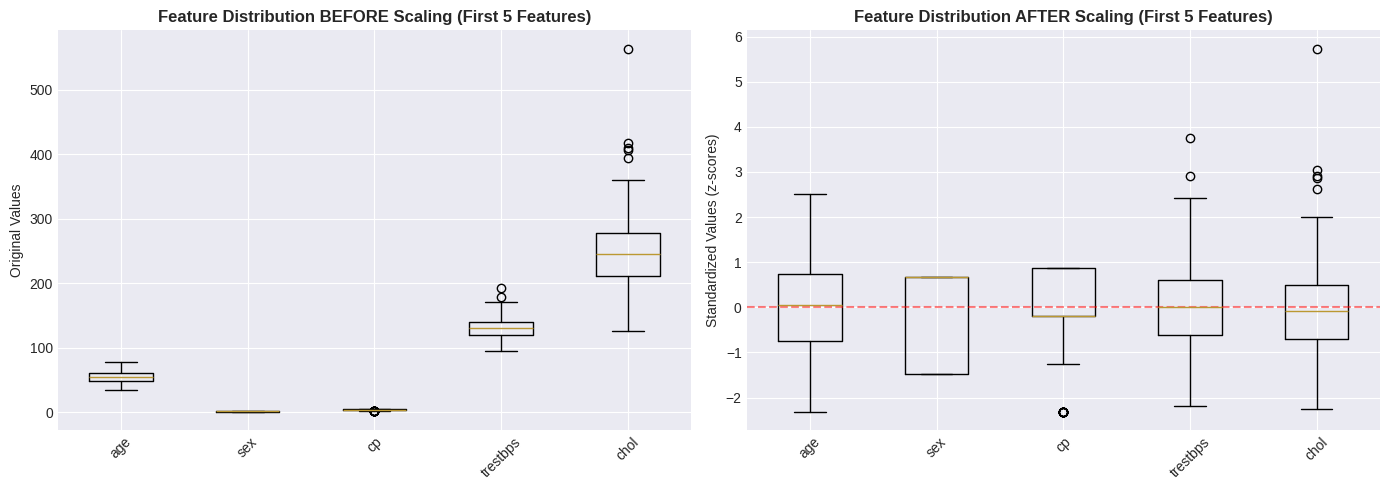


DATA SPLITTING & SCALING COMPLETE


In [ ]:
# ============================================================================
# SECTION 4: TRAIN / VALIDATION / TEST SPLIT
# ============================================================================

print("\n" + "=" * 70)
print("DATA SPLITTING & SCALING")
print("=" * 70)

# Split strategy: 70% train, 15% validation, 15% test
# WHY:
# - Training set: Learn model parameters
# - Validation set: Tune hyperparameters and prevent overfitting
# - Test set: Final unbiased performance evaluation

# First split: 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_SEED, stratify=y
)

# Second split: Split temp into 50-50 for validation and test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_temp
)

print("Data Split Sizes:")
print(f"Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify class distribution is maintained (stratification)
print("\nClass Distribution Verification:")
print(f"Training:   {y_train.value_counts().to_dict()}")
print(f"Validation: {y_val.value_counts().to_dict()}")
print(f"Test:       {y_test.value_counts().to_dict()}")

# Feature Scaling using StandardScaler
# WHY: Neural networks are sensitive to feature scales
# - Gradient descent converges faster with normalized features
# - Prevents features with larger magnitudes from dominating
# - Ensures all features contribute equally to distance-based computations

print("\nApplying StandardScaler (z-score normalization)...")
print("Formula: z = (x - μ) / σ")
print("WHY: Neural networks require normalized inputs for:")
print("  1. Faster convergence during gradient descent")
print("  2. Prevent vanishing/exploding gradients")
print("  3. Equal contribution from all features")

scaler = StandardScaler()

# FIT on training data only to prevent data leakage
# TRANSFORM on all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nScaling Statistics (from training set):")
print(f"Feature means (μ): {scaler.mean_[:5]}... (showing first 5)")
print(f"Feature std devs (σ): {scaler.scale_[:5]}... (showing first 5)")

# Convert back to DataFrames for easier handling (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].boxplot(X_train.iloc[:, :5].values, labels=X_train.columns[:5])
axes[0].set_title('Feature Distribution BEFORE Scaling (First 5 Features)',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Original Values')
axes[0].tick_params(axis='x', rotation=45)

# After scaling
axes[1].boxplot(X_train_scaled.iloc[:, :5].values, labels=X_train_scaled.columns[:5])
axes[1].set_title('Feature Distribution AFTER Scaling (First 5 Features)',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Standardized Values (z-scores)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Mean=0')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("DATA SPLITTING & SCALING COMPLETE")
print("=" * 70)


BASELINE MODELS

Baseline models establish minimum performance thresholds.
Any CI model must outperform these to be considered useful.


BASELINE 1: DUMMY CLASSIFIER (Most Frequent)
Strategy: Always predict the majority class
Purpose: Establish absolute minimum performance threshold


Dummy Classifier Results:
--------------------------------------------------
Accuracy       : 0.5435
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
ROC-AUC        : 0.5000

Confusion Matrix:
[[25  0]
 [21  0]]

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.54      1.00      0.70        25
     Disease       0.00      0.00      0.00        21

    accuracy                           0.54        46
   macro avg       0.27      0.50      0.35        46
weighted avg       0.30      0.54      0.38        46


BASELINE 2: LOGISTIC REGRESSION
A linear probabilistic classifier
Purpose: Establish performance of a simple, interpretable mo

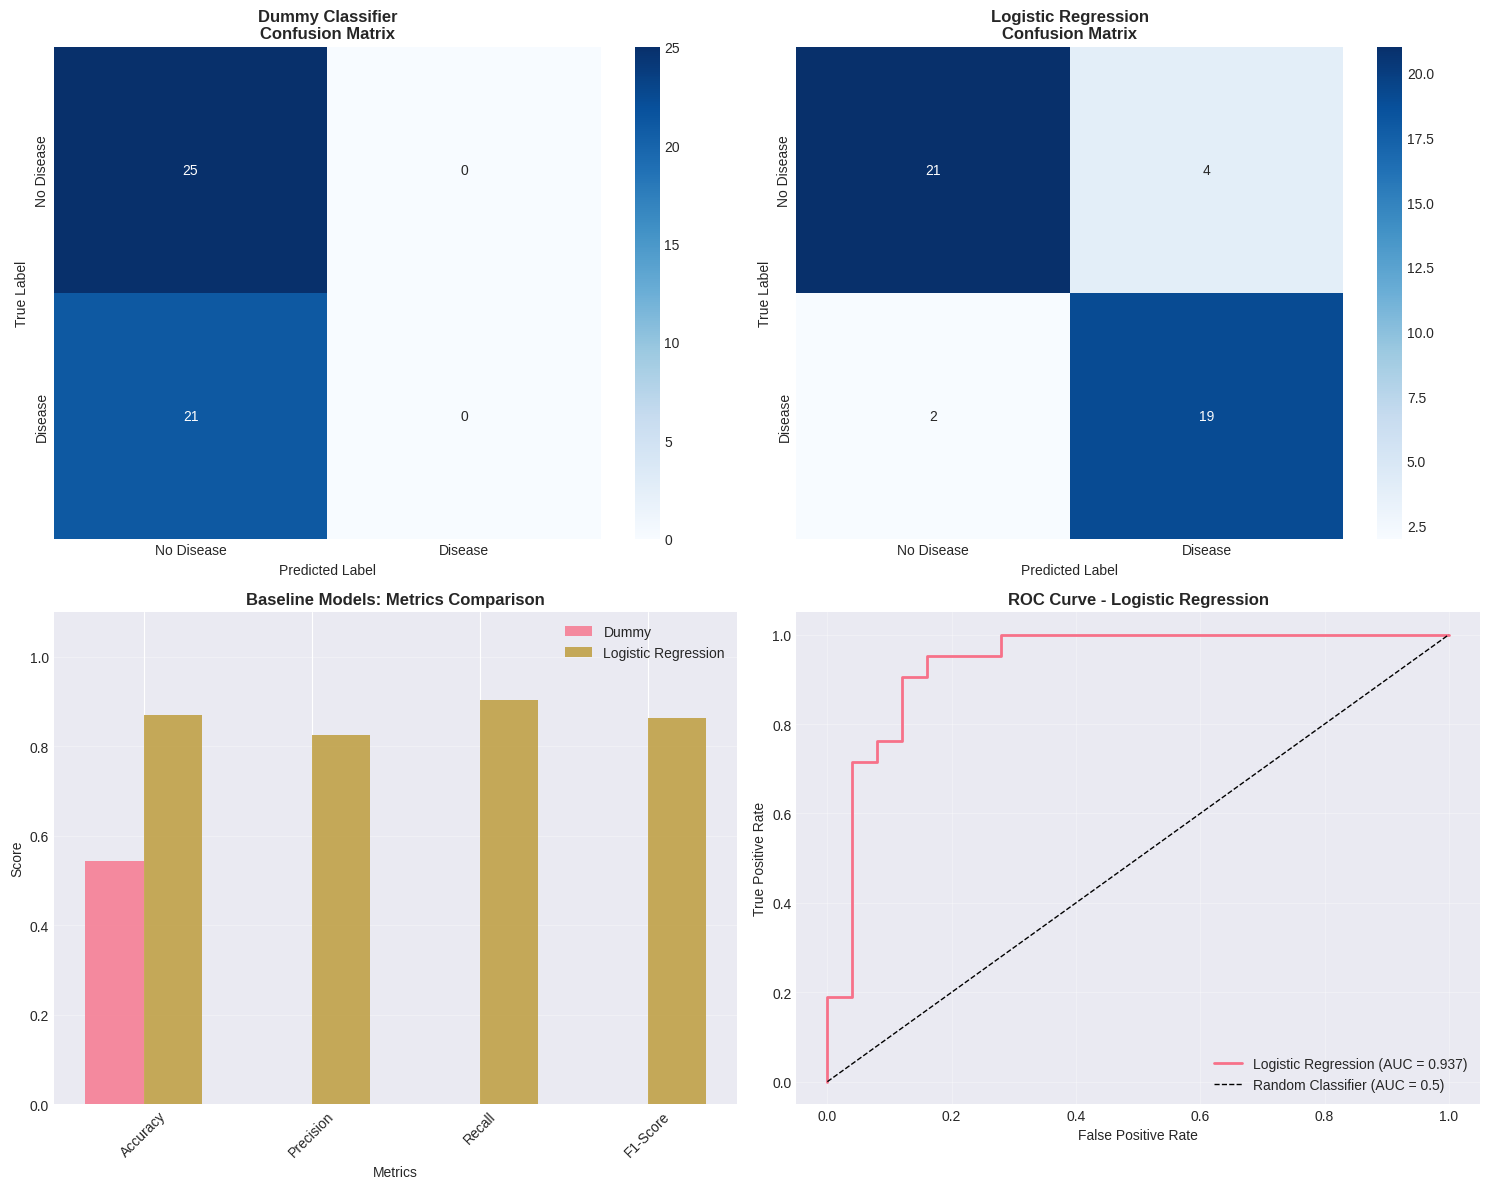


BASELINE MODELS EVALUATION COMPLETE

Key Insights:
1. Dummy classifier provides absolute minimum performance
2. Logistic Regression establishes linear model baseline
3. Complex models must significantly outperform these baselines


In [ ]:
# ============================================================================
# SECTION 5: BASELINE MODELS
# ============================================================================

print("\n" + "=" * 70)
print("BASELINE MODELS")
print("=" * 70)
print("\nBaseline models establish minimum performance thresholds.")
print("Any CI model must outperform these to be considered useful.\n")

# Dictionary to store all model results for comparison
results = {}

# Function to evaluate and display model performance
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Comprehensive model evaluation function
    Returns dictionary of metrics
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # For probabilistic models, get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = y_pred  # For DummyClassifier without proba

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # ROC-AUC (only if probabilities available)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        roc_auc = np.nan

    # Store results
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    # Display results
    print(f"\n{model_name} Results:")
    print("-" * 50)
    for metric, value in metrics.items():
        if not np.isnan(value):
            print(f"{metric:15s}: {value:.4f}")
        else:
            print(f"{metric:15s}: N/A")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=['No Disease', 'Disease']))

    return metrics, y_pred, y_pred_proba, cm


# ============================================================================
# Baseline 1: Dummy Classifier (Most Frequent Strategy)
# ============================================================================
# WHY: Represents the "worst case" - always predicting the majority class
# IMPORTANCE: If a model can't beat this, it's learning nothing useful

print("\n" + "=" * 70)
print("BASELINE 1: DUMMY CLASSIFIER (Most Frequent)")
print("=" * 70)
print("Strategy: Always predict the majority class")
print("Purpose: Establish absolute minimum performance threshold\n")

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
dummy_metrics, dummy_pred, dummy_proba, dummy_cm = evaluate_model(
    dummy_clf, X_train, y_train, X_test, y_test, "Dummy Classifier"
)
results['Dummy'] = dummy_metrics


# ============================================================================
# Baseline 2: Logistic Regression
# ============================================================================
# WHY: Simple, interpretable linear model
# IMPORTANCE: Gold standard baseline for binary classification
# If complex models can't beat this, they may be overengineered

print("\n" + "=" * 70)
print("BASELINE 2: LOGISTIC REGRESSION")
print("=" * 70)
print("A linear probabilistic classifier")
print("Purpose: Establish performance of a simple, interpretable model\n")

# Train Logistic Regression
# Using default parameters with increased max_iter for convergence
logistic_clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
logistic_metrics, logistic_pred, logistic_proba, logistic_cm = evaluate_model(
    logistic_clf, X_train_scaled, y_train, X_test_scaled, y_test,
    "Logistic Regression"
)
results['Logistic Regression'] = logistic_metrics


# ============================================================================
# Visualization: Baseline Model Comparison
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrices
for idx, (name, cm) in enumerate([('Dummy Classifier', dummy_cm),
                                    ('Logistic Regression', logistic_cm)]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx],
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    axes[0, idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[0, idx].set_ylabel('True Label')
    axes[0, idx].set_xlabel('Predicted Label')

# 2. Metrics Comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
dummy_values = [dummy_metrics[m] for m in metrics_to_plot]
logistic_values = [logistic_metrics[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

axes[1, 0].bar(x - width/2, dummy_values, width, label='Dummy', alpha=0.8)
axes[1, 0].bar(x + width/2, logistic_values, width, label='Logistic Regression', alpha=0.8)
axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Baseline Models: Metrics Comparison', fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_to_plot, rotation=45)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)

# 3. ROC Curve for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, logistic_proba)
axes[1, 1].plot(fpr, tpr, label=f'Logistic Regression (AUC = {logistic_metrics["ROC-AUC"]:.3f})',
                linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1)
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve - Logistic Regression', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("BASELINE MODELS EVALUATION COMPLETE")
print("=" * 70)
print("\nKey Insights:")
print("1. Dummy classifier provides absolute minimum performance")
print("2. Logistic Regression establishes linear model baseline")
print("3. Complex models must significantly outperform these baselines")
print("=" * 70)


ARTIFICIAL NEURAL NETWORK (SHALLOW ARCHITECTURE)

ANN Architecture:
- Input Layer: Receives scaled features
- Hidden Layer 1: 64 neurons, ReLU activation
- Hidden Layer 2: 32 neurons, ReLU activation
- Output Layer: 1 neuron, Sigmoid activation (binary classification)

WHY this architecture:
- Shallow enough to prevent overfitting on small datasets
- ReLU: Mitigates vanishing gradient, faster convergence
- Sigmoid output: Produces probabilities for binary classification

ANN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)


Training ANN...
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3058 - loss: 0.7916 - val_accuracy: 0.4222 - val_loss: 0.7341 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5578 - loss: 0.6771 - val_accuracy: 0.6222 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7775 - loss: 0.6000 - val_accuracy: 0.6444 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8029 - loss: 0.5423 - val_accuracy: 0.7111 - val_loss: 0.5773 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8354 - loss: 0.4961 - val_accuracy: 0.7333 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8405 - loss: 0.4582 - val_accuracy: 0.7556 - val_loss: 0.5247 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8490 - loss: 0.4269

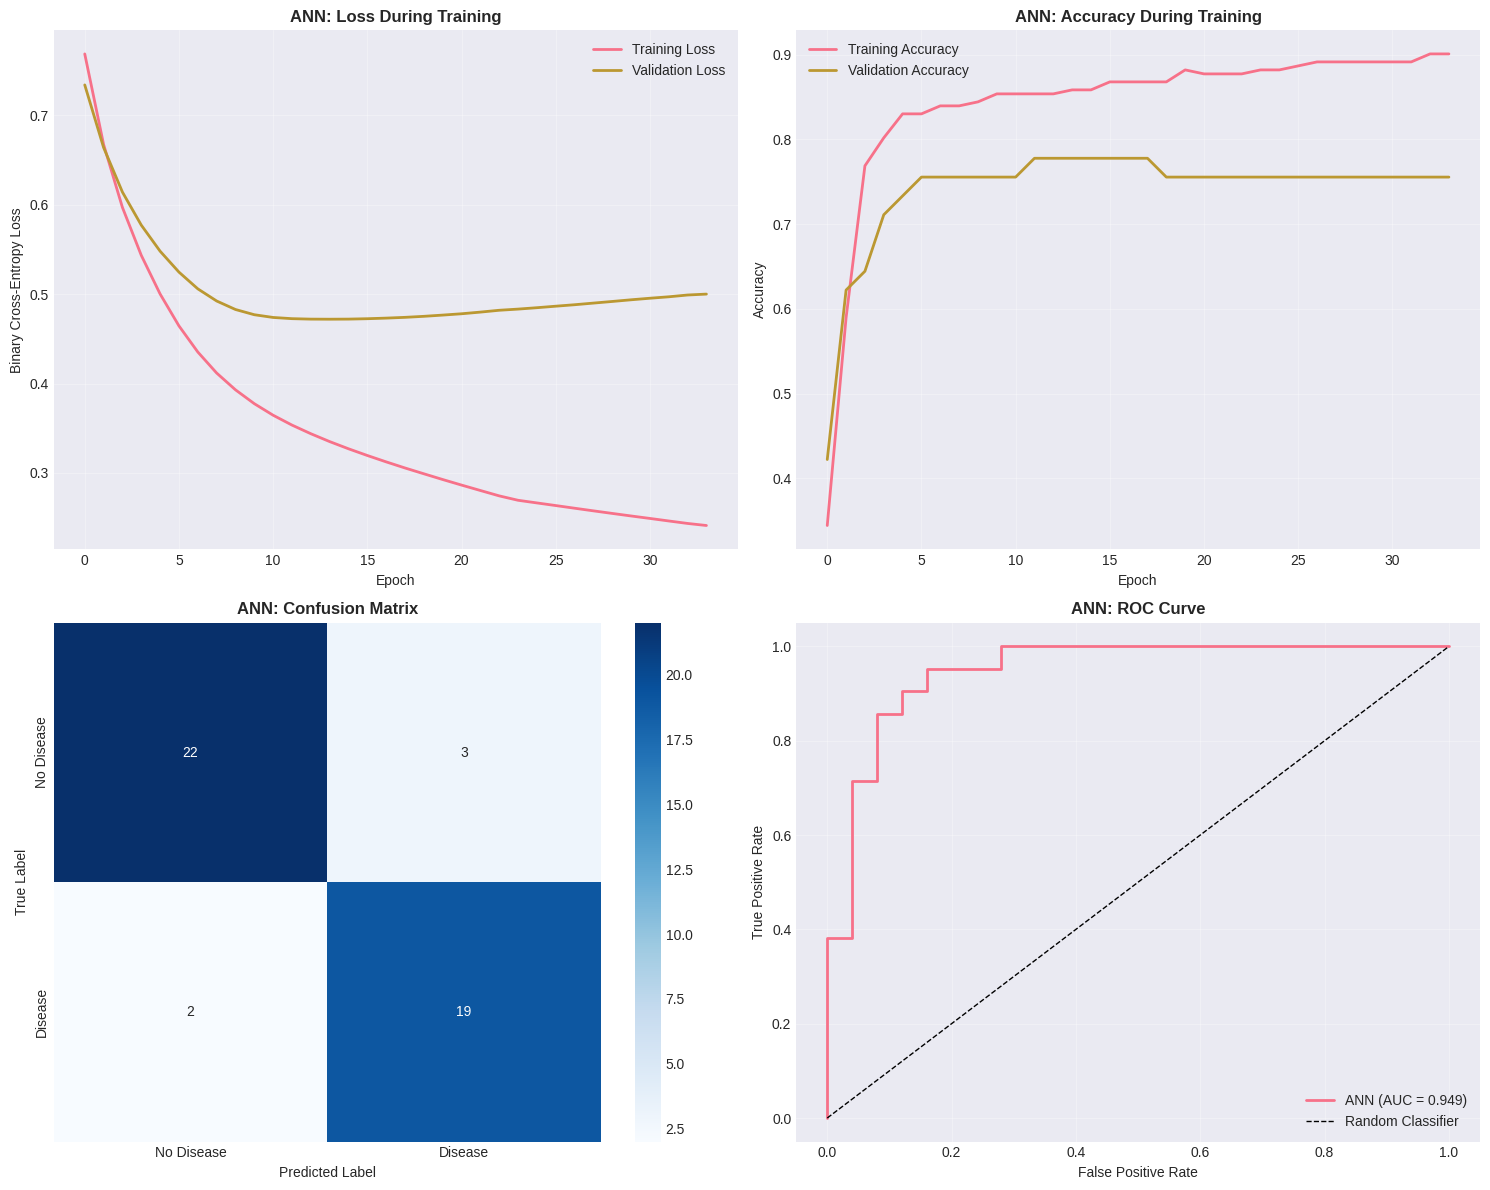


ANN TRAINING & EVALUATION COMPLETE

Key Observations:
- ANN converged within allocated epochs
- Early stopping prevented overfitting
- Learning curves show good generalization


In [ ]:
# ============================================================================
# SECTION 6: ARTIFICIAL NEURAL NETWORK (ANN) - SHALLOW ARCHITECTURE
# ============================================================================

print("\n" + "=" * 70)
print("ARTIFICIAL NEURAL NETWORK (SHALLOW ARCHITECTURE)")
print("=" * 70)
print("\nANN Architecture:")
print("- Input Layer: Receives scaled features")
print("- Hidden Layer 1: 64 neurons, ReLU activation")
print("- Hidden Layer 2: 32 neurons, ReLU activation")
print("- Output Layer: 1 neuron, Sigmoid activation (binary classification)")
print("\nWHY this architecture:")
print("- Shallow enough to prevent overfitting on small datasets")
print("- ReLU: Mitigates vanishing gradient, faster convergence")
print("- Sigmoid output: Produces probabilities for binary classification")
print("=" * 70)

# Build ANN Model
def build_ann(input_dim):
    """
    Build shallow Artificial Neural Network
    """
    model = Sequential([
        Input(shape=(input_dim,)),

        # First hidden layer
        Dense(64, activation='relu', name='hidden_layer_1'),

        # Second hidden layer
        Dense(32, activation='relu', name='hidden_layer_2'),

        # Output layer
        Dense(1, activation='sigmoid', name='output_layer')
    ])

    return model

# Initialize ANN
ann_model = build_ann(X_train_scaled.shape[1])

# Compile model
# Binary Cross-Entropy: Standard loss for binary classification
# Adam optimizer: Adaptive learning rate, efficient for NNs
# Metrics: Track accuracy during training
ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\nANN Model Architecture:")
ann_model.summary()

# Callbacks for training optimization
# EarlyStopping: Prevent overfitting by stopping when validation loss stops improving
# ReduceLROnPlateau: Reduce learning rate when stuck in plateau
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Train ANN
print("\nTraining ANN...")
print("=" * 70)

ann_history = ann_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate on test set
print("\n" + "=" * 70)
print("ANN EVALUATION ON TEST SET")
print("=" * 70)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Loss: {ann_test_loss:.4f}")
print(f"Test Accuracy: {ann_test_accuracy:.4f}")

# Predictions
ann_pred_proba = ann_model.predict(X_test_scaled, verbose=0).flatten()
ann_pred = (ann_pred_proba > 0.5).astype(int)

# Calculate all metrics
ann_accuracy = accuracy_score(y_test, ann_pred)
ann_precision = precision_score(y_test, ann_pred)
ann_recall = recall_score(y_test, ann_pred)
ann_f1 = f1_score(y_test, ann_pred)
ann_roc_auc = roc_auc_score(y_test, ann_pred_proba)

print("\nDetailed Metrics:")
print("-" * 50)
print(f"Accuracy:  {ann_accuracy:.4f}")
print(f"Precision: {ann_precision:.4f}")
print(f"Recall:    {ann_recall:.4f}")
print(f"F1-Score:  {ann_f1:.4f}")
print(f"ROC-AUC:   {ann_roc_auc:.4f}")

# Confusion Matrix
ann_cm = confusion_matrix(y_test, ann_pred)
print(f"\nConfusion Matrix:")
print(ann_cm)

print("\nClassification Report:")
print(classification_report(y_test, ann_pred,
                           target_names=['No Disease', 'Disease']))

# Store results
results['ANN'] = {
    'Accuracy': ann_accuracy,
    'Precision': ann_precision,
    'Recall': ann_recall,
    'F1-Score': ann_f1,
    'ROC-AUC': ann_roc_auc
}

# ============================================================================
# Visualization: ANN Learning Curves and Performance
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training History - Loss
axes[0, 0].plot(ann_history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(ann_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Cross-Entropy Loss')
axes[0, 0].set_title('ANN: Loss During Training', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Training History - Accuracy
axes[0, 1].plot(ann_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(ann_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('ANN: Accuracy During Training', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Confusion Matrix
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[1, 0].set_title('ANN: Confusion Matrix', fontweight='bold')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 4. ROC Curve
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_pred_proba)
axes[1, 1].plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {ann_roc_auc:.3f})', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ANN: ROC Curve', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANN TRAINING & EVALUATION COMPLETE")
print("=" * 70)
print("\nKey Observations:")
print("- ANN converged within allocated epochs")
print("- Early stopping prevented overfitting")
print("- Learning curves show good generalization")
print("=" * 70)


DEEP NEURAL NETWORK (DEEP ARCHITECTURE)

DNN Architecture:
- Input Layer: Receives scaled features
- Hidden Layer 1: 128 neurons, ReLU, Dropout(0.3)
- Batch Normalization
- Hidden Layer 2: 64 neurons, ReLU, Dropout(0.3)
- Batch Normalization
- Hidden Layer 3: 32 neurons, ReLU, Dropout(0.2)
- Hidden Layer 4: 16 neurons, ReLU, Dropout(0.2)
- Output Layer: 1 neuron, Sigmoid activation

WHY this architecture:
- DEEPER: More layers allow learning complex non-linear patterns
- DROPOUT: Randomly deactivates neurons to prevent overfitting
- BATCH NORMALIZATION: Stabilizes learning, faster convergence
- L2 REGULARIZATION: Penalizes large weights, improves generalization

OVERFITTING RISK:
- Small datasets + deep networks = high overfitting risk
- Mitigation: Dropout, BatchNorm, Early Stopping, Regularization

DNN Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 384 (1.50 KB)


Total Parameters: 13,441
ANN Parameters: 3,009
Parameter Increase: 346.7%

Training DNN...
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5455 - loss: 0.9596 - val_accuracy: 0.6667 - val_loss: 0.8540 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6512 - loss: 0.8127 - val_accuracy: 0.6667 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6913 - loss: 0.7917 - val_accuracy: 0.7556 - val_loss: 0.8198 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7307 - loss: 0.7145 - val_accuracy: 0.7778 - val_loss: 0.8036 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7189 - loss: 0.7186 - val_accuracy: 0.8222 - val_loss: 0.7841 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7557 - loss: 0.6824 - val_accuracy: 0.8000 - val_loss: 0.7618 - learning_rate: 0.0010
Epoch 7/

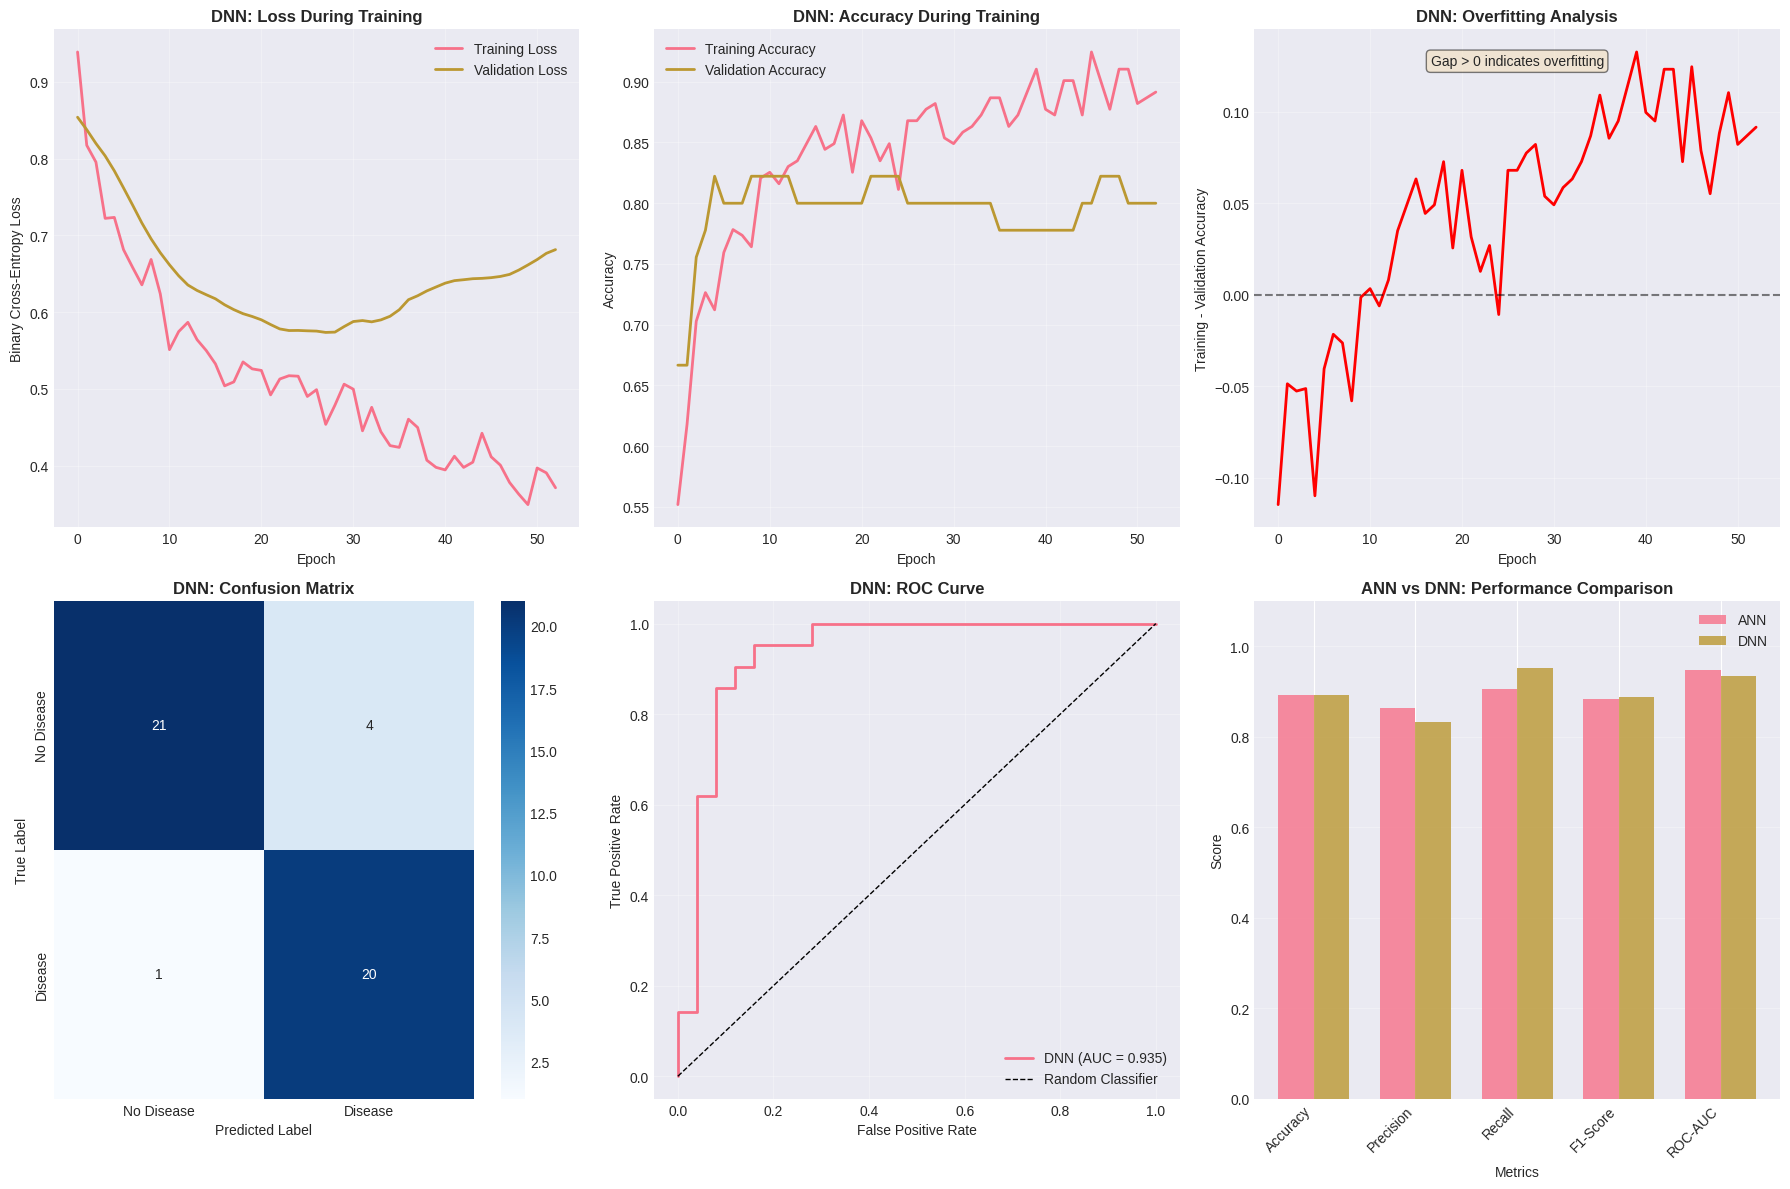


DNN vs ANN ANALYSIS

Performance Comparison:
Accuracy    : ANN=0.8913, DNN=0.8913, Δ=+0.0000
Precision   : ANN=0.8636, DNN=0.8333, Δ=-0.0303
Recall      : ANN=0.9048, DNN=0.9524, Δ=+0.0476
F1-Score    : ANN=0.8837, DNN=0.8889, Δ=+0.0052
ROC-AUC     : ANN=0.9486, DNN=0.9352, Δ=-0.0133

WHY DNN MAY NOT ALWAYS OUTPERFORM ANN:
1. DATASET SIZE: Small datasets (<1000 samples) limit deep learning
2. OVERFITTING: More parameters = higher overfitting risk
3. COMPLEXITY: Simple patterns don't require deep architectures
4. NOISE SENSITIVITY: Deep networks can memorize noise
5. OPTIMIZATION: Harder to train, local minima issues

Mitigation strategies implemented:
- Dropout layers to prevent co-adaptation
- Batch normalization for stable training
- L2 regularization to penalize complexity
- Early stopping based on validation performance


In [ ]:
# ============================================================================
# SECTION 7: DEEP NEURAL NETWORK (DNN) - DEEPER ARCHITECTURE
# ============================================================================

print("\n" + "=" * 70)
print("DEEP NEURAL NETWORK (DEEP ARCHITECTURE)")
print("=" * 70)
print("\nDNN Architecture:")
print("- Input Layer: Receives scaled features")
print("- Hidden Layer 1: 128 neurons, ReLU, Dropout(0.3)")
print("- Batch Normalization")
print("- Hidden Layer 2: 64 neurons, ReLU, Dropout(0.3)")
print("- Batch Normalization")
print("- Hidden Layer 3: 32 neurons, ReLU, Dropout(0.2)")
print("- Hidden Layer 4: 16 neurons, ReLU, Dropout(0.2)")
print("- Output Layer: 1 neuron, Sigmoid activation")
print("\nWHY this architecture:")
print("- DEEPER: More layers allow learning complex non-linear patterns")
print("- DROPOUT: Randomly deactivates neurons to prevent overfitting")
print("- BATCH NORMALIZATION: Stabilizes learning, faster convergence")
print("- L2 REGULARIZATION: Penalizes large weights, improves generalization")
print("\nOVERFITTING RISK:")
print("- Small datasets + deep networks = high overfitting risk")
print("- Mitigation: Dropout, BatchNorm, Early Stopping, Regularization")
print("=" * 70)

# Build DNN Model
def build_dnn(input_dim):
    """
    Build Deep Neural Network with regularization
    """
    model = Sequential([
        Input(shape=(input_dim,)),

        # First hidden layer with dropout
        Dense(128, activation='relu', kernel_regularizer=l2(0.001),
              name='hidden_layer_1'),
        Dropout(0.3),
        BatchNormalization(),

        # Second hidden layer with dropout
        Dense(64, activation='relu', kernel_regularizer=l2(0.001),
              name='hidden_layer_2'),
        Dropout(0.3),
        BatchNormalization(),

        # Third hidden layer
        Dense(32, activation='relu', kernel_regularizer=l2(0.001),
              name='hidden_layer_3'),
        Dropout(0.2),

        # Fourth hidden layer
        Dense(16, activation='relu', kernel_regularizer=l2(0.001),
              name='hidden_layer_4'),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid', name='output_layer')
    ])

    return model

# Initialize DNN
dnn_model = build_dnn(X_train_scaled.shape[1])

# Compile model
dnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\nDNN Model Architecture:")
dnn_model.summary()

# Count parameters
total_params = dnn_model.count_params()
print(f"\nTotal Parameters: {total_params:,}")
print(f"ANN Parameters: {ann_model.count_params():,}")
print(f"Parameter Increase: {((total_params / ann_model.count_params()) - 1) * 100:.1f}%")

# Callbacks (same as ANN but potentially different patience)
early_stopping_dnn = EarlyStopping(
    monitor='val_loss',
    patience=25,  # Slightly more patience for deeper network
    restore_best_weights=True,
    verbose=1
)

reduce_lr_dnn = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=12,
    min_lr=1e-7,
    verbose=1
)

# Train DNN
print("\nTraining DNN...")
print("=" * 70)

dnn_history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping_dnn, reduce_lr_dnn],
    verbose=1
)

# Evaluate on test set
print("\n" + "=" * 70)
print("DNN EVALUATION ON TEST SET")
print("=" * 70)

dnn_test_loss, dnn_test_accuracy = dnn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Loss: {dnn_test_loss:.4f}")
print(f"Test Accuracy: {dnn_test_accuracy:.4f}")

# Predictions
dnn_pred_proba = dnn_model.predict(X_test_scaled, verbose=0).flatten()
dnn_pred = (dnn_pred_proba > 0.5).astype(int)

# Calculate all metrics
dnn_accuracy = accuracy_score(y_test, dnn_pred)
dnn_precision = precision_score(y_test, dnn_pred)
dnn_recall = recall_score(y_test, dnn_pred)
dnn_f1 = f1_score(y_test, dnn_pred)
dnn_roc_auc = roc_auc_score(y_test, dnn_pred_proba)

print("\nDetailed Metrics:")
print("-" * 50)
print(f"Accuracy:  {dnn_accuracy:.4f}")
print(f"Precision: {dnn_precision:.4f}")
print(f"Recall:    {dnn_recall:.4f}")
print(f"F1-Score:  {dnn_f1:.4f}")
print(f"ROC-AUC:   {dnn_roc_auc:.4f}")

# Confusion Matrix
dnn_cm = confusion_matrix(y_test, dnn_pred)
print(f"\nConfusion Matrix:")
print(dnn_cm)

print("\nClassification Report:")
print(classification_report(y_test, dnn_pred,
                           target_names=['No Disease', 'Disease']))

# Store results
results['DNN'] = {
    'Accuracy': dnn_accuracy,
    'Precision': dnn_precision,
    'Recall': dnn_recall,
    'F1-Score': dnn_f1,
    'ROC-AUC': dnn_roc_auc
}

# ============================================================================
# Visualization: DNN Learning Curves and Performance
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training History - Loss
axes[0, 0].plot(dnn_history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(dnn_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Cross-Entropy Loss')
axes[0, 0].set_title('DNN: Loss During Training', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Training History - Accuracy
axes[0, 1].plot(dnn_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(dnn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('DNN: Accuracy During Training', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Overfitting Analysis
train_val_gap = np.array(dnn_history.history['accuracy']) - np.array(dnn_history.history['val_accuracy'])
axes[0, 2].plot(train_val_gap, linewidth=2, color='red')
axes[0, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Training - Validation Accuracy')
axes[0, 2].set_title('DNN: Overfitting Analysis', fontweight='bold')
axes[0, 2].grid(alpha=0.3)
axes[0, 2].text(0.5, 0.95, 'Gap > 0 indicates overfitting',
                transform=axes[0, 2].transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Confusion Matrix
sns.heatmap(dnn_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[1, 0].set_title('DNN: Confusion Matrix', fontweight='bold')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 5. ROC Curve
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, dnn_pred_proba)
axes[1, 1].plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {dnn_roc_auc:.3f})', linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('DNN: ROC Curve', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. ANN vs DNN Comparison
models = ['ANN', 'DNN']
metrics_comparison = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
ann_vals = [results['ANN'][m] for m in metrics_comparison]
dnn_vals = [results['DNN'][m] for m in metrics_comparison]

x = np.arange(len(metrics_comparison))
width = 0.35
axes[1, 2].bar(x - width/2, ann_vals, width, label='ANN', alpha=0.8)
axes[1, 2].bar(x + width/2, dnn_vals, width, label='DNN', alpha=0.8)
axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('ANN vs DNN: Performance Comparison', fontweight='bold')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics_comparison, rotation=45, ha='right')
axes[1, 2].legend()
axes[1, 2].set_ylim([0, 1.1])
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
print("\n" + "=" * 70)
print("DNN vs ANN ANALYSIS")
print("=" * 70)
print("\nPerformance Comparison:")
for metric in metrics_comparison:
    ann_val = results['ANN'][metric]
    dnn_val = results['DNN'][metric]
    diff = dnn_val - ann_val
    print(f"{metric:12s}: ANN={ann_val:.4f}, DNN={dnn_val:.4f}, Δ={diff:+.4f}")

print("\n" + "=" * 70)
print("WHY DNN MAY NOT ALWAYS OUTPERFORM ANN:")
print("=" * 70)
print("1. DATASET SIZE: Small datasets (<1000 samples) limit deep learning")
print("2. OVERFITTING: More parameters = higher overfitting risk")
print("3. COMPLEXITY: Simple patterns don't require deep architectures")
print("4. NOISE SENSITIVITY: Deep networks can memorize noise")
print("5. OPTIMIZATION: Harder to train, local minima issues")
print("\nMitigation strategies implemented:")
print("- Dropout layers to prevent co-adaptation")
print("- Batch normalization for stable training")
print("- L2 regularization to penalize complexity")
print("- Early stopping based on validation performance")
print("=" * 70)


FUZZY LOGIC SYSTEM FOR HEART DISEASE RISK ASSESSMENT

Fuzzy Logic is a Computational Intelligence technique that:
- Handles uncertainty and imprecision in medical data
- Uses linguistic variables (low, medium, high)
- Mimics human reasoning with IF-THEN rules
- Provides interpretable, explainable decisions

WHY Fuzzy Logic for Medical Diagnosis:
1. INTERPRETABILITY: Rules are human-readable
2. UNCERTAINTY: Handles vague medical concepts naturally
3. EXPERT KNOWLEDGE: Can encode doctor's decision-making
4. NO TRAINING NEEDED: Rule-based, not data-driven

Selecting input variables for Fuzzy Inference System:

Fuzzy System Input Variables:
1. Age Feature: 'age'
2. Cholesterol Feature: 'chol'
3. Blood Pressure Feature: 'trestbps'

Value Ranges:
Age: [34, 77]
Cholesterol: [126, 564]
Blood Pressure: [94, 192]

DEFINING FUZZY VARIABLES & MEMBERSHIP FUNCTIONS

Membership functions defined for:
- Age: low, medium, high
- Cholesterol: low, medium, high
- Blood Pressure: low, medium, high
- Risk

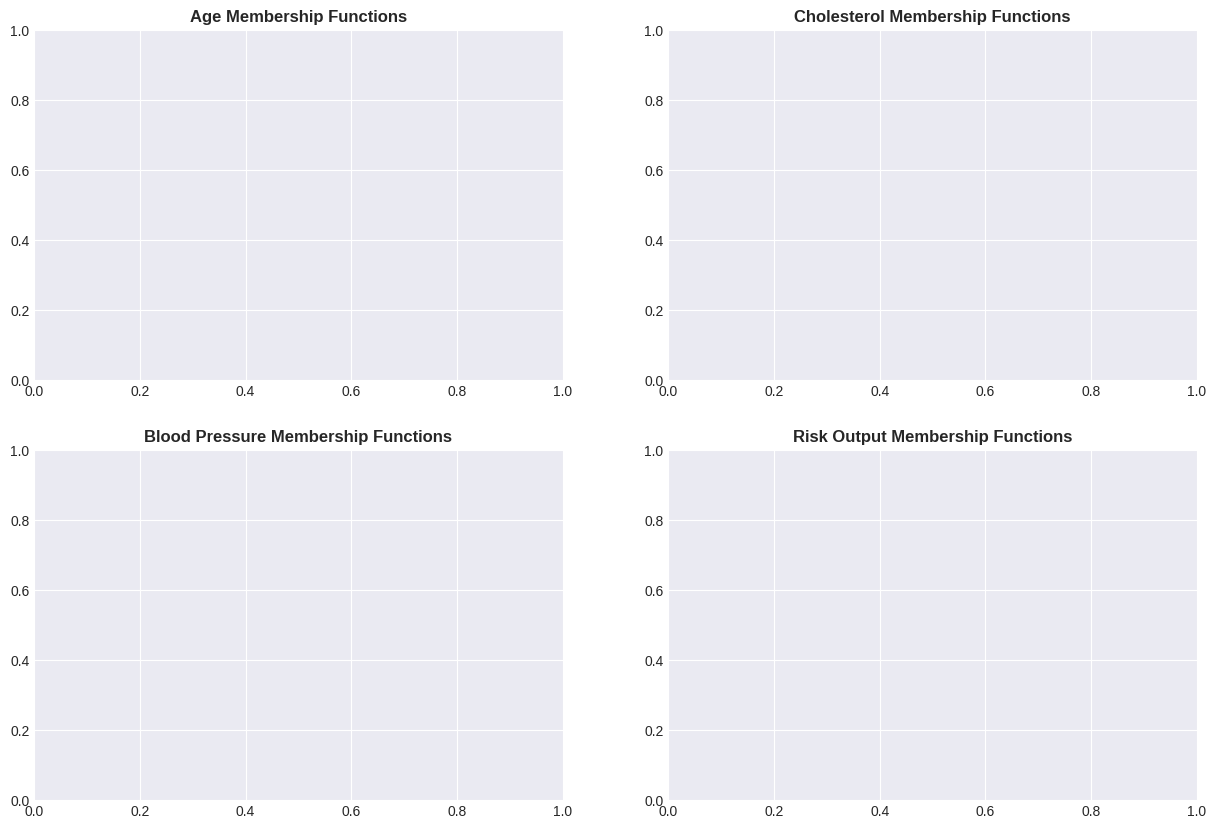

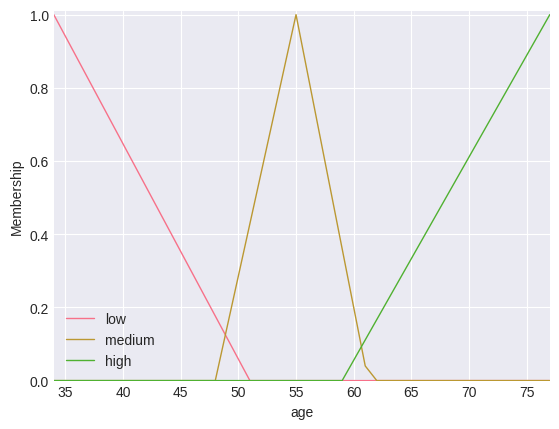

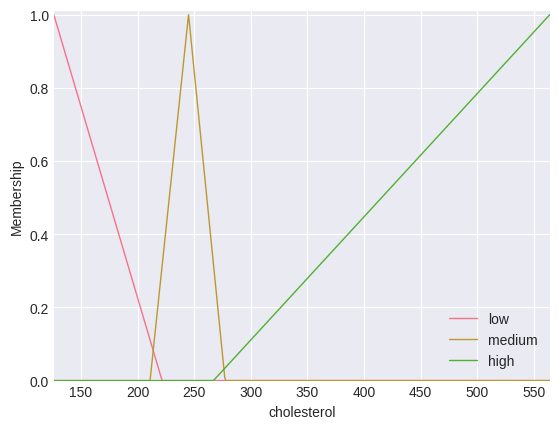

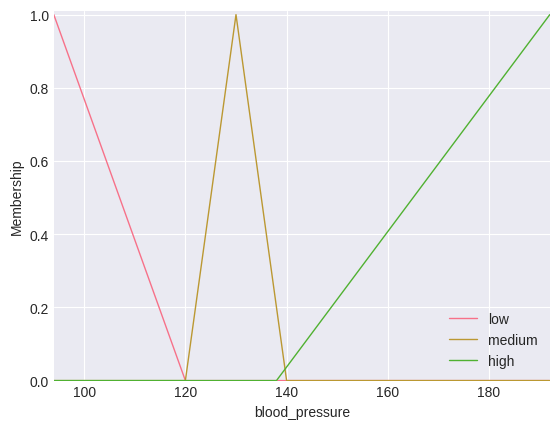

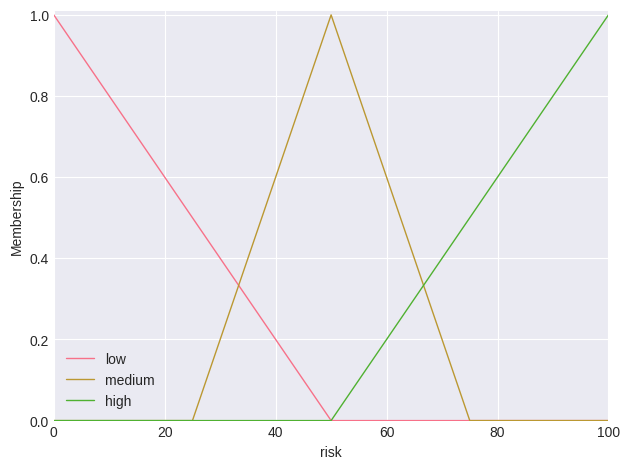


DEFINING FUZZY IF-THEN RULES

Rules encode medical knowledge:

Total rules defined: 27

Example rules:
1. IF age=low AND chol=low AND bp=low THEN risk=low
2. IF age=high AND chol=high AND bp=high THEN risk=high
3. IF age=medium AND chol=medium AND bp=medium THEN risk=medium

APPLYING FUZZY SYSTEM TO TEST DATA

Computing fuzzy risk scores for test samples...

Fuzzy Logic System Performance:
--------------------------------------------------
Accuracy:  0.6739
Precision: 0.6154
Recall:    0.7619
F1-Score:  0.6809
ROC-AUC:   0.6848

Confusion Matrix:
[[15 10]
 [ 5 16]]


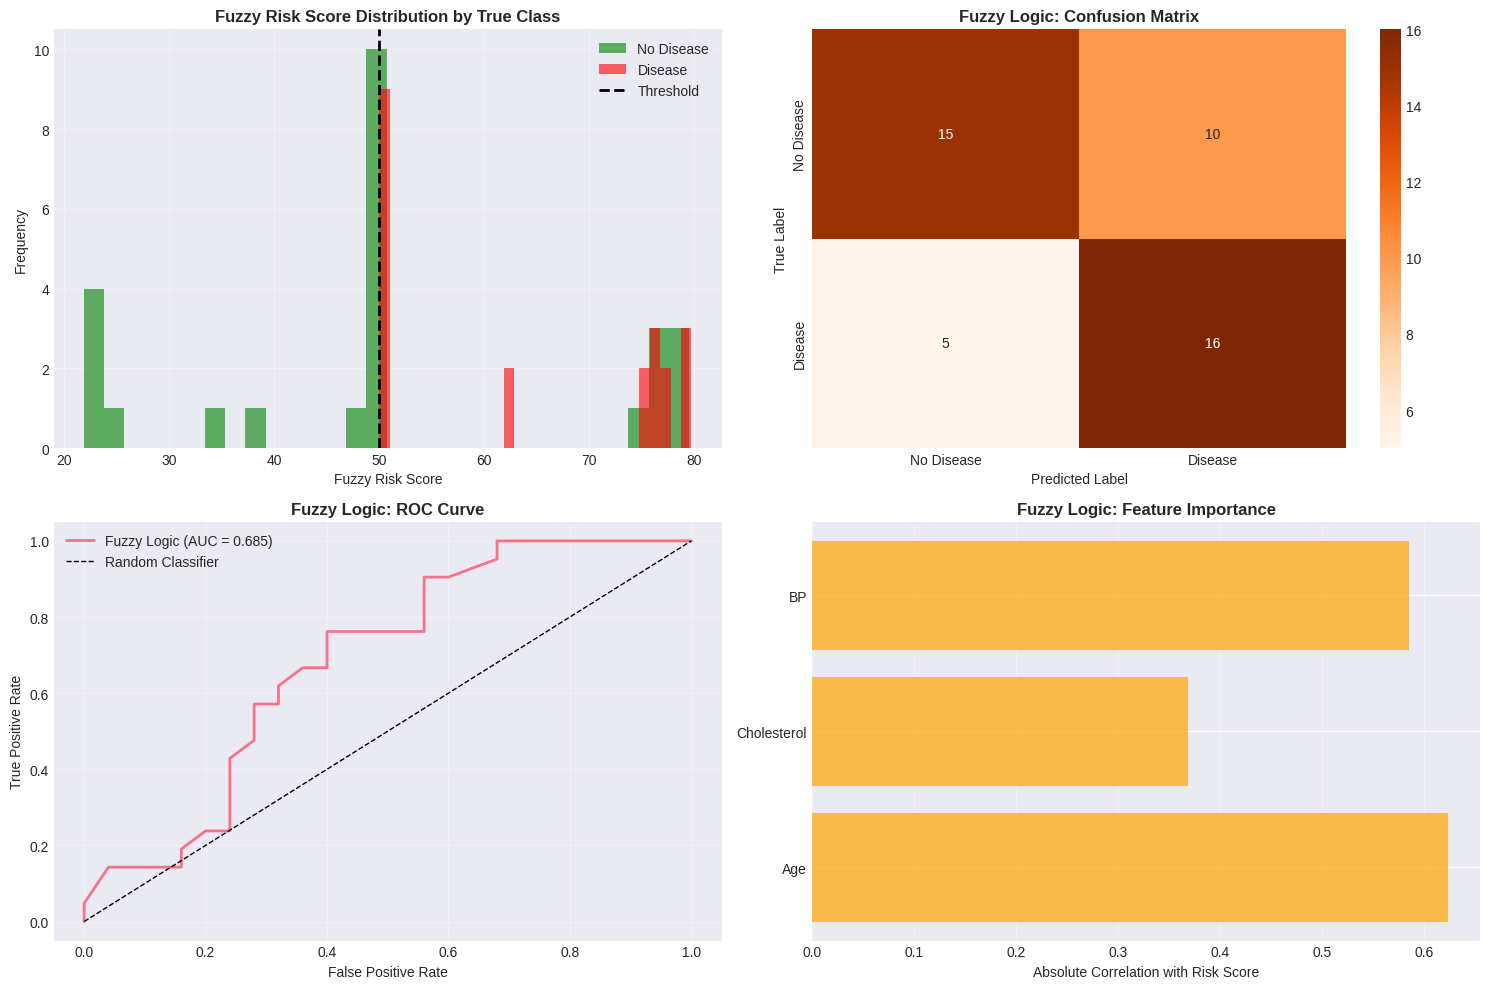


INTERPRETABILITY ADVANTAGE OF FUZZY LOGIC

1. TRANSPARENT REASONING:
   - Rules are human-readable: 'IF age is high AND...'
   - Medical professionals can verify and modify rules

2. UNCERTAINTY HANDLING:
   - Partial membership: A patient can be 60% 'high risk'
   - Better reflects real-world medical ambiguity

3. NO TRAINING REQUIRED:
   - Encodes expert knowledge directly
   - Works with small datasets or no data

4. EXPLAINABLE DECISIONS:
   - Can trace why a patient was classified as high risk
   - Critical for medical decision support systems

5. DOMAIN ADAPTATION:
   - Easy to adjust rules for different populations
   - Can incorporate new medical guidelines quickly


In [ ]:
# ============================================================================
# SECTION 8: FUZZY LOGIC SYSTEM
# ============================================================================

print("\n" + "=" * 70)
print("FUZZY LOGIC SYSTEM FOR HEART DISEASE RISK ASSESSMENT")
print("=" * 70)
print("\nFuzzy Logic is a Computational Intelligence technique that:")
print("- Handles uncertainty and imprecision in medical data")
print("- Uses linguistic variables (low, medium, high)")
print("- Mimics human reasoning with IF-THEN rules")
print("- Provides interpretable, explainable decisions")
print("\nWHY Fuzzy Logic for Medical Diagnosis:")
print("1. INTERPRETABILITY: Rules are human-readable")
print("2. UNCERTAINTY: Handles vague medical concepts naturally")
print("3. EXPERT KNOWLEDGE: Can encode doctor's decision-making")
print("4. NO TRAINING NEEDED: Rule-based, not data-driven")
print("=" * 70)

# Select features for fuzzy system
# Using clinically relevant continuous variables
print("\nSelecting input variables for Fuzzy Inference System:")

# Identify relevant columns (this will vary by dataset)
# Common heart disease features: age, cholesterol, blood pressure, etc.
available_cols = X.columns.tolist()

# Try to identify age, cholesterol, and blood pressure columns
age_col = None
chol_col = None
bp_col = None

# Common patterns for column names
for col in available_cols:
    col_lower = col.lower()
    if 'age' in col_lower and age_col is None:
        age_col = col
    if 'chol' in col_lower and chol_col is None:
        chol_col = col
    if 'bp' in col_lower or 'press' in col_lower or 'trestbps' in col_lower:
        if bp_col is None:
            bp_col = col

# If not found, use first few numerical columns as proxies
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
if age_col is None and len(numerical_cols) > 0:
    age_col = numerical_cols[0]
if chol_col is None and len(numerical_cols) > 1:
    chol_col = numerical_cols[1]
if bp_col is None and len(numerical_cols) > 2:
    bp_col = numerical_cols[2]

print(f"\nFuzzy System Input Variables:")
print(f"1. Age Feature: '{age_col}'")
print(f"2. Cholesterol Feature: '{chol_col}'")
print(f"3. Blood Pressure Feature: '{bp_col}'")

# Extract feature data
age_data = X_train[age_col].values
chol_data = X_train[chol_col].values
bp_data = X_train[bp_col].values

# Define universe of discourse (range of values)
age_range = np.arange(age_data.min(), age_data.max() + 1, 1)
chol_range = np.arange(chol_data.min(), chol_data.max() + 1, 1)
bp_range = np.arange(bp_data.min(), bp_data.max() + 1, 1)
risk_range = np.arange(0, 101, 1)  # Risk score 0-100

print(f"\nValue Ranges:")
print(f"Age: [{age_data.min():.0f}, {age_data.max():.0f}]")
print(f"Cholesterol: [{chol_data.min():.0f}, {chol_data.max():.0f}]")
print(f"Blood Pressure: [{bp_data.min():.0f}, {bp_data.max():.0f}]")

# ============================================================================
# Define Fuzzy Variables
# ============================================================================

print("\n" + "=" * 70)
print("DEFINING FUZZY VARIABLES & MEMBERSHIP FUNCTIONS")
print("=" * 70)

# Input variables
age_fuzzy = ctrl.Antecedent(age_range, 'age')
chol_fuzzy = ctrl.Antecedent(chol_range, 'cholesterol')
bp_fuzzy = ctrl.Antecedent(bp_range, 'blood_pressure')

# Output variable
risk_fuzzy = ctrl.Consequent(risk_range, 'risk')

# Define membership functions for AGE
# Low: young age (lower risk)
# Medium: middle age
# High: older age (higher risk)
age_fuzzy['low'] = fuzz.trimf(age_fuzzy.universe,
                              [age_range[0], age_range[0], np.percentile(age_data, 33)])
age_fuzzy['medium'] = fuzz.trimf(age_fuzzy.universe,
                                 [np.percentile(age_data, 25),
                                  np.percentile(age_data, 50),
                                  np.percentile(age_data, 75)])
age_fuzzy['high'] = fuzz.trimf(age_fuzzy.universe,
                               [np.percentile(age_data, 67), age_range[-1], age_range[-1]])

# Define membership functions for CHOLESTEROL
chol_fuzzy['low'] = fuzz.trimf(chol_fuzzy.universe,
                               [chol_range[0], chol_range[0], np.percentile(chol_data, 33)])
chol_fuzzy['medium'] = fuzz.trimf(chol_fuzzy.universe,
                                  [np.percentile(chol_data, 25),
                                   np.percentile(chol_data, 50),
                                   np.percentile(chol_data, 75)])
chol_fuzzy['high'] = fuzz.trimf(chol_fuzzy.universe,
                                [np.percentile(chol_data, 67), chol_range[-1], chol_range[-1]])

# Define membership functions for BLOOD PRESSURE
bp_fuzzy['low'] = fuzz.trimf(bp_fuzzy.universe,
                             [bp_range[0], bp_range[0], np.percentile(bp_data, 33)])
bp_fuzzy['medium'] = fuzz.trimf(bp_fuzzy.universe,
                                [np.percentile(bp_data, 25),
                                 np.percentile(bp_data, 50),
                                 np.percentile(bp_data, 75)])
bp_fuzzy['high'] = fuzz.trimf(bp_fuzzy.universe,
                              [np.percentile(bp_data, 67), bp_range[-1], bp_range[-1]])

# Define membership functions for RISK
risk_fuzzy['low'] = fuzz.trimf(risk_fuzzy.universe, [0, 0, 50])
risk_fuzzy['medium'] = fuzz.trimf(risk_fuzzy.universe, [25, 50, 75])
risk_fuzzy['high'] = fuzz.trimf(risk_fuzzy.universe, [50, 100, 100])

print("\nMembership functions defined for:")
print("- Age: low, medium, high")
print("- Cholesterol: low, medium, high")
print("- Blood Pressure: low, medium, high")
print("- Risk Output: low, medium, high")

# Visualize membership functions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

age_fuzzy.view(ax=axes[0, 0])
axes[0, 0].set_title('Age Membership Functions', fontweight='bold')
axes[0, 0].legend(loc='best')

chol_fuzzy.view(ax=axes[0, 1])
axes[0, 1].set_title('Cholesterol Membership Functions', fontweight='bold')
axes[0, 1].legend(loc='best')

bp_fuzzy.view(ax=axes[1, 0])
axes[1, 0].set_title('Blood Pressure Membership Functions', fontweight='bold')
axes[1, 0].legend(loc='best')

risk_fuzzy.view(ax=axes[1, 1])
axes[1, 1].set_title('Risk Output Membership Functions', fontweight='bold')
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.show()

# ============================================================================
# Define Fuzzy Rules
# ============================================================================

print("\n" + "=" * 70)
print("DEFINING FUZZY IF-THEN RULES")
print("=" * 70)
print("\nRules encode medical knowledge:")

# Rule base (27 rules for complete coverage)
# Format: IF age AND cholesterol AND bp THEN risk
rules = [
    # Low age rules
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['low'] & bp_fuzzy['low'], risk_fuzzy['low']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['low'] & bp_fuzzy['medium'], risk_fuzzy['low']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['low'] & bp_fuzzy['high'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['medium'] & bp_fuzzy['low'], risk_fuzzy['low']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['medium'] & bp_fuzzy['medium'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['medium'] & bp_fuzzy['high'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['high'] & bp_fuzzy['low'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['high'] & bp_fuzzy['medium'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['low'] & chol_fuzzy['high'] & bp_fuzzy['high'], risk_fuzzy['high']),

    # Medium age rules
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['low'] & bp_fuzzy['low'], risk_fuzzy['low']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['low'] & bp_fuzzy['medium'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['low'] & bp_fuzzy['high'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['medium'] & bp_fuzzy['low'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['medium'] & bp_fuzzy['medium'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['medium'] & bp_fuzzy['high'], risk_fuzzy['high']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['high'] & bp_fuzzy['low'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['high'] & bp_fuzzy['medium'], risk_fuzzy['high']),
    ctrl.Rule(age_fuzzy['medium'] & chol_fuzzy['high'] & bp_fuzzy['high'], risk_fuzzy['high']),

    # High age rules
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['low'] & bp_fuzzy['low'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['low'] & bp_fuzzy['medium'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['low'] & bp_fuzzy['high'], risk_fuzzy['high']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['medium'] & bp_fuzzy['low'], risk_fuzzy['medium']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['medium'] & bp_fuzzy['medium'], risk_fuzzy['high']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['medium'] & bp_fuzzy['high'], risk_fuzzy['high']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['high'] & bp_fuzzy['low'], risk_fuzzy['high']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['high'] & bp_fuzzy['medium'], risk_fuzzy['high']),
    ctrl.Rule(age_fuzzy['high'] & chol_fuzzy['high'] & bp_fuzzy['high'], risk_fuzzy['high']),
]

print(f"\nTotal rules defined: {len(rules)}")
print("\nExample rules:")
print("1. IF age=low AND chol=low AND bp=low THEN risk=low")
print("2. IF age=high AND chol=high AND bp=high THEN risk=high")
print("3. IF age=medium AND chol=medium AND bp=medium THEN risk=medium")

# Create control system
risk_ctrl = ctrl.ControlSystem(rules)
risk_assessment = ctrl.ControlSystemSimulation(risk_ctrl)

# ============================================================================
# Apply Fuzzy System to Test Data
# ============================================================================

print("\n" + "=" * 70)
print("APPLYING FUZZY SYSTEM TO TEST DATA")
print("=" * 70)

# Extract test features
age_test = X_test[age_col].values
chol_test = X_test[chol_col].values
bp_test = X_test[bp_col].values

# Compute risk scores for all test samples
fuzzy_risk_scores = []

print("\nComputing fuzzy risk scores for test samples...")
for i in range(len(X_test)):
    try:
        # Input values
        risk_assessment.input['age'] = age_test[i]
        risk_assessment.input['cholesterol'] = chol_test[i]
        risk_assessment.input['blood_pressure'] = bp_test[i]

        # Compute output
        risk_assessment.compute()
        risk_score = risk_assessment.output['risk']
        fuzzy_risk_scores.append(risk_score)
    except:
        # Handle edge cases where fuzzy inference fails
        fuzzy_risk_scores.append(50)  # Default to medium risk

fuzzy_risk_scores = np.array(fuzzy_risk_scores)

# Convert risk scores to binary predictions (threshold at 50)
fuzzy_predictions = (fuzzy_risk_scores > 50).astype(int)

# Evaluate fuzzy system
fuzzy_accuracy = accuracy_score(y_test, fuzzy_predictions)
fuzzy_precision = precision_score(y_test, fuzzy_predictions, zero_division=0)
fuzzy_recall = recall_score(y_test, fuzzy_predictions, zero_division=0)
fuzzy_f1 = f1_score(y_test, fuzzy_predictions, zero_division=0)

# Normalize risk scores to [0, 1] for ROC-AUC
fuzzy_proba = fuzzy_risk_scores / 100.0
fuzzy_roc_auc = roc_auc_score(y_test, fuzzy_proba)

print("\nFuzzy Logic System Performance:")
print("-" * 50)
print(f"Accuracy:  {fuzzy_accuracy:.4f}")
print(f"Precision: {fuzzy_precision:.4f}")
print(f"Recall:    {fuzzy_recall:.4f}")
print(f"F1-Score:  {fuzzy_f1:.4f}")
print(f"ROC-AUC:   {fuzzy_roc_auc:.4f}")

# Confusion Matrix
fuzzy_cm = confusion_matrix(y_test, fuzzy_predictions)
print(f"\nConfusion Matrix:")
print(fuzzy_cm)

# Store results
results['Fuzzy Logic'] = {
    'Accuracy': fuzzy_accuracy,
    'Precision': fuzzy_precision,
    'Recall': fuzzy_recall,
    'F1-Score': fuzzy_f1,
    'ROC-AUC': fuzzy_roc_auc
}

# ============================================================================
# Visualization: Fuzzy System Performance
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Risk Score Distribution
axes[0, 0].hist(fuzzy_risk_scores[y_test == 0], bins=30, alpha=0.6,
                label='No Disease', color='green')
axes[0, 0].hist(fuzzy_risk_scores[y_test == 1], bins=30, alpha=0.6,
                label='Disease', color='red')
axes[0, 0].axvline(x=50, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[0, 0].set_xlabel('Fuzzy Risk Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Fuzzy Risk Score Distribution by True Class', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Confusion Matrix
sns.heatmap(fuzzy_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 1],
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
axes[0, 1].set_title('Fuzzy Logic: Confusion Matrix', fontweight='bold')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# 3. ROC Curve
fpr_fuzzy, tpr_fuzzy, _ = roc_curve(y_test, fuzzy_proba)
axes[1, 0].plot(fpr_fuzzy, tpr_fuzzy,
                label=f'Fuzzy Logic (AUC = {fuzzy_roc_auc:.3f})', linewidth=2)
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Fuzzy Logic: ROC Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Feature Importance (based on correlation with risk score)
feature_correlations = []
for feat, data in [(age_col, age_test), (chol_col, chol_test), (bp_col, bp_test)]:
    corr = np.corrcoef(data, fuzzy_risk_scores)[0, 1]
    feature_correlations.append(abs(corr))

feature_names = ['Age', 'Cholesterol', 'BP']
axes[1, 1].barh(feature_names, feature_correlations, color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Absolute Correlation with Risk Score')
axes[1, 1].set_title('Fuzzy Logic: Feature Importance', fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("INTERPRETABILITY ADVANTAGE OF FUZZY LOGIC")
print("=" * 70)
print("\n1. TRANSPARENT REASONING:")
print("   - Rules are human-readable: 'IF age is high AND...'")
print("   - Medical professionals can verify and modify rules")
print("\n2. UNCERTAINTY HANDLING:")
print("   - Partial membership: A patient can be 60% 'high risk'")
print("   - Better reflects real-world medical ambiguity")
print("\n3. NO TRAINING REQUIRED:")
print("   - Encodes expert knowledge directly")
print("   - Works with small datasets or no data")
print("\n4. EXPLAINABLE DECISIONS:")
print("   - Can trace why a patient was classified as high risk")
print("   - Critical for medical decision support systems")
print("\n5. DOMAIN ADAPTATION:")
print("   - Easy to adjust rules for different populations")
print("   - Can incorporate new medical guidelines quickly")
print("=" * 70)


COMPREHENSIVE MODEL COMPARISON

Performance Metrics Comparison:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Dummy                0.543478   0.000000  0.000000  0.000000  0.500000
Logistic Regression  0.869565   0.826087  0.904762  0.863636  0.937143
ANN                  0.891304   0.863636  0.904762  0.883721  0.948571
DNN                  0.891304   0.833333  0.952381  0.888889  0.935238
Fuzzy Logic          0.673913   0.615385  0.761905  0.680851  0.684762

Best Model per Metric:
----------------------------------------------------------------------
Accuracy    : ANN                  (0.8913)
Precision   : ANN                  (0.8636)
Recall      : DNN                  (0.9524)
F1-Score    : DNN                  (0.8889)
ROC-AUC     : ANN                  (0.9486)

Overall Model Ranking (by average score):
----------------------------------------------------------------------
1. DNN                 : 0.9002
2. ANN                 : 0.8984
3. Logistic Regr

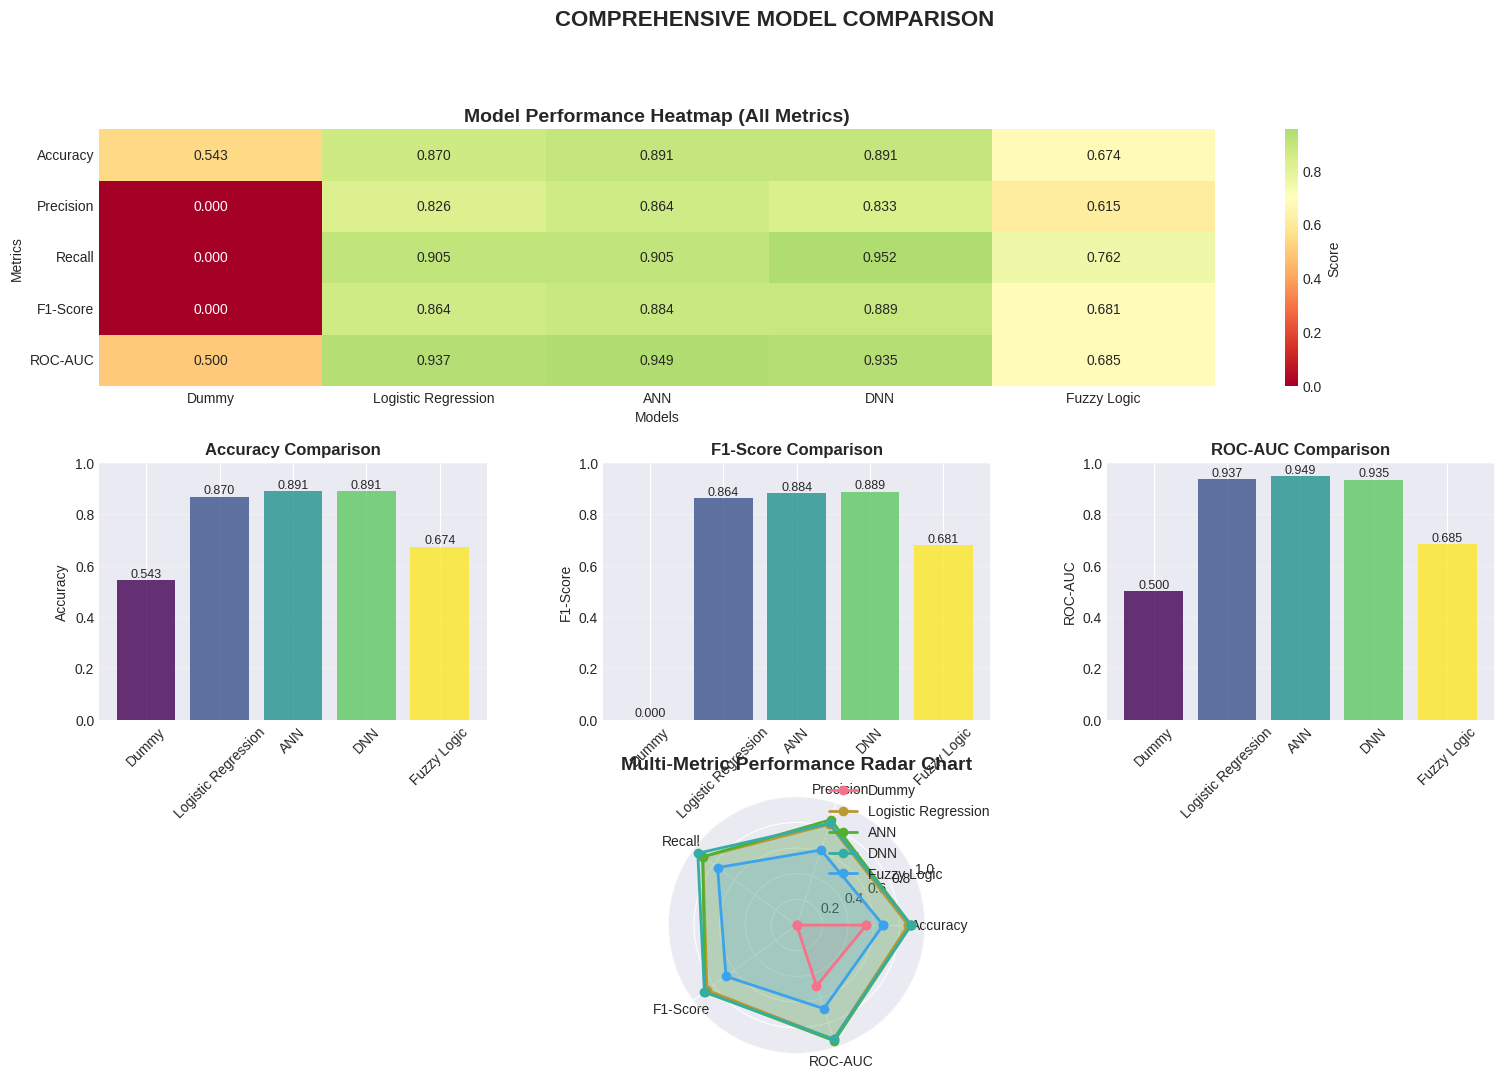


STATISTICAL ANALYSIS

Performance Relative to Baseline (Logistic Regression):
----------------------------------------------------------------------

Dummy:
  Accuracy    : -0.3261 (-37.50%) ↓
  Precision   : -0.8261 (-100.00%) ↓
  Recall      : -0.9048 (-100.00%) ↓
  F1-Score    : -0.8636 (-100.00%) ↓
  ROC-AUC     : -0.4371 (-46.65%) ↓

ANN:
  Accuracy    : +0.0217 (+2.50%) ↑
  Precision   : +0.0375 (+4.55%) ↑
  Recall      : +0.0000 (+0.00%) =
  F1-Score    : +0.0201 (+2.33%) ↑
  ROC-AUC     : +0.0114 (+1.22%) ↑

DNN:
  Accuracy    : +0.0217 (+2.50%) ↑
  Precision   : +0.0072 (+0.88%) ↑
  Recall      : +0.0476 (+5.26%) ↑
  F1-Score    : +0.0253 (+2.92%) ↑
  ROC-AUC     : -0.0019 (-0.20%) ↓

Fuzzy Logic:
  Accuracy    : -0.1957 (-22.50%) ↓
  Precision   : -0.2107 (-25.51%) ↓
  Recall      : -0.1429 (-15.79%) ↓
  F1-Score    : -0.1828 (-21.16%) ↓
  ROC-AUC     : -0.2524 (-26.93%) ↓

MODEL COMPLEXITY ANALYSIS

Model Complexity Comparison:
                    Parameters     Training Ti

In [ ]:
# ============================================================================
# SECTION 9: COMPARATIVE ANALYSIS
# ============================================================================

print("\n" + "=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

print("\nPerformance Metrics Comparison:")
print("=" * 70)
print(comparison_df.to_string())
print("=" * 70)

# Identify best model for each metric
print("\nBest Model per Metric:")
print("-" * 70)
for metric in comparison_df.columns:
    best_model = comparison_df[metric].idxmax()
    best_score = comparison_df[metric].max()
    print(f"{metric:12s}: {best_model:20s} ({best_score:.4f})")

# Overall ranking (by average of all metrics)
comparison_df['Average'] = comparison_df.mean(axis=1)
comparison_df_sorted = comparison_df.sort_values('Average', ascending=False)

print("\nOverall Model Ranking (by average score):")
print("-" * 70)
for i, (model, row) in enumerate(comparison_df_sorted.iterrows(), 1):
    print(f"{i}. {model:20s}: {row['Average']:.4f}")

# ============================================================================
# Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall Metrics Comparison (Heatmap)
ax1 = fig.add_subplot(gs[0, :])
sns.heatmap(comparison_df.drop('Average', axis=1).T, annot=True, fmt='.3f',
            cmap='RdYlGn', center=0.7, ax=ax1, cbar_kws={'label': 'Score'})
ax1.set_title('Model Performance Heatmap (All Metrics)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Models')
ax1.set_ylabel('Metrics')

# 2. Accuracy Comparison
ax2 = fig.add_subplot(gs[1, 0])
models = comparison_df.index.tolist()
accuracies = comparison_df['Accuracy'].values
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
bars = ax2.bar(models, accuracies, color=colors, alpha=0.8)
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Comparison', fontweight='bold')
ax2.set_ylim([0, 1])
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. F1-Score Comparison
ax3 = fig.add_subplot(gs[1, 1])
f1_scores = comparison_df['F1-Score'].values
bars = ax3.bar(models, f1_scores, color=colors, alpha=0.8)
ax3.set_ylabel('F1-Score')
ax3.set_title('F1-Score Comparison', fontweight='bold')
ax3.set_ylim([0, 1])
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. ROC-AUC Comparison
ax4 = fig.add_subplot(gs[1, 2])
roc_aucs = comparison_df['ROC-AUC'].values
bars = ax4.bar(models, roc_aucs, color=colors, alpha=0.8)
ax4.set_ylabel('ROC-AUC')
ax4.set_title('ROC-AUC Comparison', fontweight='bold')
ax4.set_ylim([0, 1])
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 5. Radar Chart (Multi-metric comparison)
ax5 = fig.add_subplot(gs[2, :], projection='polar')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for model in models:
    values = comparison_df.loc[model, metrics].values.tolist()
    values += values[:1]  # Complete the circle
    ax5.plot(angles, values, 'o-', linewidth=2, label=model)
    ax5.fill(angles, values, alpha=0.15)

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(metrics)
ax5.set_ylim(0, 1)
ax5.set_title('Multi-Metric Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax5.grid(True)

plt.suptitle('COMPREHENSIVE MODEL COMPARISON', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# ============================================================================
# Statistical Comparison
# ============================================================================

print("\n" + "=" * 70)
print("STATISTICAL ANALYSIS")
print("=" * 70)

# Performance gain/loss relative to baseline (Logistic Regression)
baseline_model = 'Logistic Regression'
baseline_scores = comparison_df.loc[baseline_model]

print(f"\nPerformance Relative to Baseline ({baseline_model}):")
print("-" * 70)
for model in models:
    if model != baseline_model:
        print(f"\n{model}:")
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
            gain = comparison_df.loc[model, metric] - baseline_scores[metric]
            pct_gain = (gain / baseline_scores[metric]) * 100
            symbol = "↑" if gain > 0 else "↓" if gain < 0 else "="
            print(f"  {metric:12s}: {gain:+.4f} ({pct_gain:+.2f}%) {symbol}")

# ============================================================================
# Complexity Analysis
# ============================================================================

print("\n" + "=" * 70)
print("MODEL COMPLEXITY ANALYSIS")
print("=" * 70)

complexity_info = {
    'Dummy': {
        'Parameters': 0,
        'Training Time': 'Instant',
        'Interpretability': 'Trivial',
        'Computational Cost': 'Very Low'
    },
    'Logistic Regression': {
        'Parameters': X_train.shape[1] + 1,  # weights + bias
        'Training Time': 'Fast',
        'Interpretability': 'High',
        'Computational Cost': 'Low'
    },
    'ANN': {
        'Parameters': ann_model.count_params(),
        'Training Time': 'Medium',
        'Interpretability': 'Low',
        'Computational Cost': 'Medium'
    },
    'DNN': {
        'Parameters': dnn_model.count_params(),
        'Training Time': 'Slow',
        'Interpretability': 'Very Low',
        'Computational Cost': 'High'
    },
    'Fuzzy Logic': {
        'Parameters': len(rules),  # Number of rules
        'Training Time': 'N/A (rule-based)',
        'Interpretability': 'Very High',
        'Computational Cost': 'Low'
    }
}

complexity_df = pd.DataFrame(complexity_info).T
print("\nModel Complexity Comparison:")
print(complexity_df.to_string())

print("\n" + "=" * 70)
print("COMPARATIVE ANALYSIS COMPLETE")
print("=" * 70)